In [200]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [201]:
df = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")
# df = pd.read_csv("daily.csv")
df.sort_values('date', inplace=True)
df.head(5)

,date,state,positive,probableCases,negative,pending,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,...,dataQualityGrade,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score,grade
20779,20200113,WA,NaN,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,NaN,0,0,12b994ad07c276a5278a2465e081751688739765,0,0,0,0,0,NaN
20778,20200114,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,NaN,0,0,1881c8a2f0d337b22066b4f05df06eb2259e8d57,0,0,0,0,0,NaN
20777,20200115,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,NaN,0,0,4987e61aad88182abfe641033b597304c2153d4f,0,0,0,0,0,NaN
20776,20200116,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,NaN,0,0,650501e005a5ee86d93c5f32dda56735ea2af967,0,0,0,0,0,NaN
20775,20200117,WA,0.0,NaN,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,...,NaN,0,0,7cefac6b3681020741ca30f45399a7b22f2e45b4,0,0,0,0,0,NaN


## checking for null values 

In [202]:
df.isnull().sum()

date                               0
state                              0
positive                         188
probableCases                  11509
negative                        7490
pending                        18642
totalTestResultsSource             0
totalTestResults                 166
hospitalizedCurrently           3441
hospitalizedCumulative          8398
inIcuCurrently                  9144
inIcuCumulative                16991
onVentilatorCurrently          11654
onVentilatorCumulative         19490
recovered                       8777
lastUpdateEt                     616
dateModified                     616
checkTimeEt                      616
death                            850
hospitalized                    8398
hospitalizedDischarged         17710
dateChecked                      616
totalTestsViral                 6264
positiveTestsViral             11822
negativeTestsViral             15756
positiveCasesViral              6534
deathConfirmed                 11358
d

## removing columns having `null` values for which 40% or more data points are `null`

In [203]:
columns = df.columns
len_df = len(df)
for col in columns:
    if df[col].isnull().sum() > 0.5 * len_df:
        df.drop(col, inplace=True, axis=1)

In [204]:
df.isnull().sum()

date                           0
state                          0
positive                     188
negative                    7490
totalTestResultsSource         0
totalTestResults             166
hospitalizedCurrently       3441
hospitalizedCumulative      8398
inIcuCurrently              9144
recovered                   8777
lastUpdateEt                 616
dateModified                 616
checkTimeEt                  616
death                        850
hospitalized                8398
dateChecked                  616
totalTestsViral             6264
positiveCasesViral          6534
fips                           0
positiveIncrease               0
negativeIncrease               0
total                          0
totalTestResultsIncrease       0
posNeg                         0
deathIncrease                  0
hospitalizedIncrease           0
hash                           0
commercialScore                0
negativeRegularScore           0
negativeScore                  0
positiveSc

### filling `NaN` with `0`

In [205]:
df

,date,state,positive,negative,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,recovered,...,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
20779,20200113,WA,NaN,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,12b994ad07c276a5278a2465e081751688739765,0,0,0,0,0
20778,20200114,WA,0.0,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1881c8a2f0d337b22066b4f05df06eb2259e8d57,0,0,0,0,0
20777,20200115,WA,0.0,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,4987e61aad88182abfe641033b597304c2153d4f,0,0,0,0,0
20776,20200116,WA,0.0,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,650501e005a5ee86d93c5f32dda56735ea2af967,0,0,0,0,0
20775,20200117,WA,0.0,NaN,totalTestEncountersViral,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,7cefac6b3681020741ca30f45399a7b22f2e45b4,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,20210307,NE,203026.0,771128.0,totalTestsViral,2421684.0,137.0,6237.0,NaN,157144.0,...,1,974154,0,8,3f55dc5e02818a3abbd58e07cf80bdfe4abc60f1,0,0,0,0,0
31,20210307,ND,100391.0,305912.0,totalTestEncountersViral,1425146.0,23.0,3880.0,3.0,98326.0,...,679,406303,0,2,ee1d9ce00226b7456452f7d4f6674248577e0c4b,0,0,0,0,0
30,20210307,NC,872176.0,NaN,totalTestsViral,9688838.0,1179.0,NaN,309.0,NaN,...,0,872176,0,0,d9ca67dd72ba6f8a8506ebb734fd25b0b8067608,0,0,0,0,0
28,20210307,MS,297581.0,1459374.0,posNeg,1756955.0,419.0,9162.0,89.0,278162.0,...,260,1756955,3,0,38d600ef762a2cde624501169ffae710e94913fe,0,0,0,0,0


In [206]:
df.fillna(0, inplace=True)

In [207]:
df.isnull().sum()

date                        0
state                       0
positive                    0
negative                    0
totalTestResultsSource      0
totalTestResults            0
hospitalizedCurrently       0
hospitalizedCumulative      0
inIcuCurrently              0
recovered                   0
lastUpdateEt                0
dateModified                0
checkTimeEt                 0
death                       0
hospitalized                0
dateChecked                 0
totalTestsViral             0
positiveCasesViral          0
fips                        0
positiveIncrease            0
negativeIncrease            0
total                       0
totalTestResultsIncrease    0
posNeg                      0
deathIncrease               0
hospitalizedIncrease        0
hash                        0
commercialScore             0
negativeRegularScore        0
negativeScore               0
positiveScore               0
score                       0
dtype: int64

In [208]:
df

,date,state,positive,negative,totalTestResultsSource,totalTestResults,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,recovered,...,totalTestResultsIncrease,posNeg,deathIncrease,hospitalizedIncrease,hash,commercialScore,negativeRegularScore,negativeScore,positiveScore,score
20779,20200113,WA,0.0,0.0,totalTestEncountersViral,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,12b994ad07c276a5278a2465e081751688739765,0,0,0,0,0
20778,20200114,WA,0.0,0.0,totalTestEncountersViral,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1881c8a2f0d337b22066b4f05df06eb2259e8d57,0,0,0,0,0
20777,20200115,WA,0.0,0.0,totalTestEncountersViral,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,4987e61aad88182abfe641033b597304c2153d4f,0,0,0,0,0
20776,20200116,WA,0.0,0.0,totalTestEncountersViral,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,650501e005a5ee86d93c5f32dda56735ea2af967,0,0,0,0,0
20775,20200117,WA,0.0,0.0,totalTestEncountersViral,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,7cefac6b3681020741ca30f45399a7b22f2e45b4,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,20210307,NE,203026.0,771128.0,totalTestsViral,2421684.0,137.0,6237.0,0.0,157144.0,...,1,974154,0,8,3f55dc5e02818a3abbd58e07cf80bdfe4abc60f1,0,0,0,0,0
31,20210307,ND,100391.0,305912.0,totalTestEncountersViral,1425146.0,23.0,3880.0,3.0,98326.0,...,679,406303,0,2,ee1d9ce00226b7456452f7d4f6674248577e0c4b,0,0,0,0,0
30,20210307,NC,872176.0,0.0,totalTestsViral,9688838.0,1179.0,0.0,309.0,0.0,...,0,872176,0,0,d9ca67dd72ba6f8a8506ebb734fd25b0b8067608,0,0,0,0,0
28,20210307,MS,297581.0,1459374.0,posNeg,1756955.0,419.0,9162.0,89.0,278162.0,...,260,1756955,3,0,38d600ef762a2cde624501169ffae710e94913fe,0,0,0,0,0


## checking if every state and date has unique entries or not? 

In [209]:
df.groupby(["date", "state"])['state'].count().value_counts()

1    20780
Name: state, dtype: int64

## Dropping values which does not add any aid to predictions

In [210]:
# drop variables with few/no variations
df.drop(
    ['hash', 
    'commercialScore', 
    'fips', 
    'hospitalizedIncrease', 
    'negativeRegularScore', 
    'totalTestResultsSource',
    'negativeScore', 
    'positiveScore', 
    'score', 
    "lastUpdateEt",
    "dateModified",
    "dateChecked",
    "checkTimeEt",
    'totalTestsViral'], axis=1, inplace=True)

## checking for negative values in data 

- `positiveIncrease` - New positive Cases
- `deathIncrease` - New death cases
- `hospitalizedCurrently` - current hospitalisation count
- `totalTestResultsIncrease` - New tests


In [211]:
df.columns

Index(['date', 'state', 'positive', 'negative', 'totalTestResults',
       'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently',
       'recovered', 'death', 'hospitalized', 'positiveCasesViral',
       'positiveIncrease', 'negativeIncrease', 'total',
       'totalTestResultsIncrease', 'posNeg', 'deathIncrease'],
      dtype='object')

In [212]:
if df.apply(
    lambda x: 
        x.positiveIncrease < 0 or
        x.deathIncrease < 0 or 
        x.totalTestResultsIncrease < 0 or 
        x.hospitalizedCurrently < 0, axis=1).any():
        print("negative values are present in columns -> ['positiveIncrease', 'deathIncrease', 'totalTestResultsIncrease', 'hospitalizedCurrently']")
else:
    print("no negative values are present in columns -> ['positiveIncrease', 'deathIncrease', 'totalTestResultsIncrease', 'hospitalizedCurrently']")

negative values are present in columns -> ['positiveIncrease', 'deathIncrease', 'totalTestResultsIncrease', 'hospitalizedCurrently']


## Treating Negative values

In [213]:
df.loc[df.positiveIncrease < 0, 'positiveIncrease'] = 0
df.loc[df.deathIncrease < 0, 'deathIncrease'] = 0 
df.loc[df.totalTestResultsIncrease < 0, 'totalTestResultsIncrease'] = 0
df.loc[df.hospitalizedCurrently < 0, 'hospitalizedCurrently'] = 0


In [214]:
if df.apply(
    lambda x: 
        x.positiveIncrease < 0 or
        x.deathIncrease < 0 or 
        x.totalTestResultsIncrease < 0 or 
        x.hospitalizedCurrently < 0, axis=1).any():
        print("negative values are present in columns -> ['positiveIncrease', 'deathIncrease', 'totalTestResultsIncrease', 'hospitalizedCurrently']")
else:
    print("no negative values are present in columns -> ['positiveIncrease', 'deathIncrease', 'totalTestResultsIncrease', 'hospitalizedCurrently']")

no negative values are present in columns -> ['positiveIncrease', 'deathIncrease', 'totalTestResultsIncrease', 'hospitalizedCurrently']


## Summing up Entire Data date wise to aggregate Data at US Country Level


In [215]:
data_df = df.groupby("date").sum().reset_index()
data_df.date = pd.to_datetime(data_df['date'], format='%Y%m%d')
data_df = data_df.sort_values(by='date')
data_df['date_ordinal'] = data_df['date'].apply(pd.Timestamp.toordinal)

## Data type info

In [216]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 420 entries, 0 to 419
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      420 non-null    datetime64[ns]
 1   positive                  420 non-null    float64       
 2   negative                  420 non-null    float64       
 3   totalTestResults          420 non-null    float64       
 4   hospitalizedCurrently     420 non-null    float64       
 5   hospitalizedCumulative    420 non-null    float64       
 6   inIcuCurrently            420 non-null    float64       
 7   recovered                 420 non-null    float64       
 8   death                     420 non-null    float64       
 9   hospitalized              420 non-null    float64       
 10  positiveCasesViral        420 non-null    float64       
 11  positiveIncrease          420 non-null    int64         
 12  negativeIncrease      

## Finding columns which are highly correlated or of having highest correlation 

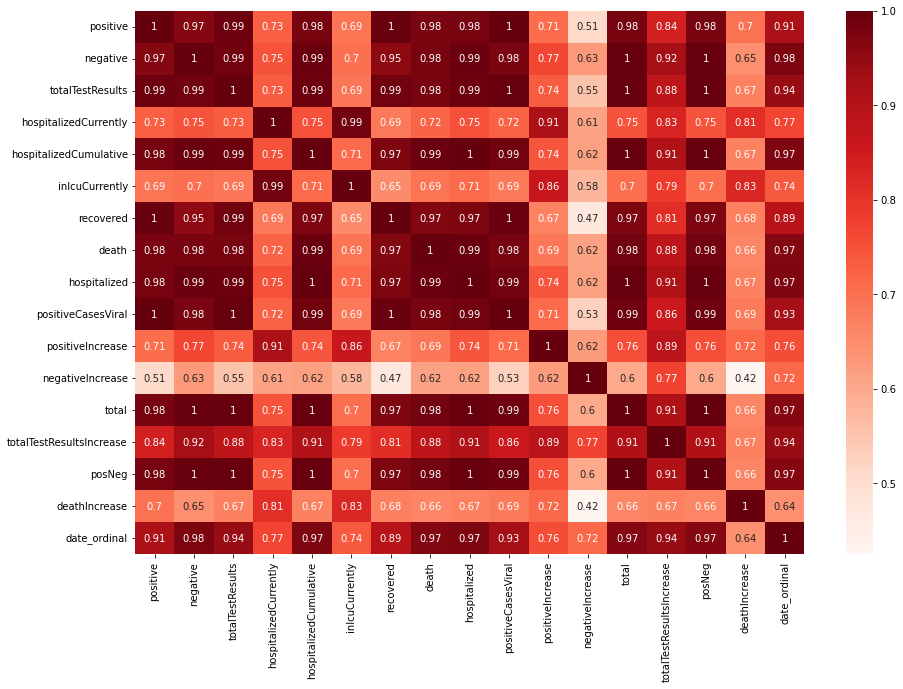

In [217]:
#Using Pearson Correlation
plt.figure(figsize=(15,10))
corr = data_df.corr()

sns.heatmap(corr, annot=True, cmap=plt.cm.Reds)
plt.show()


## Histogram Distribution Plot

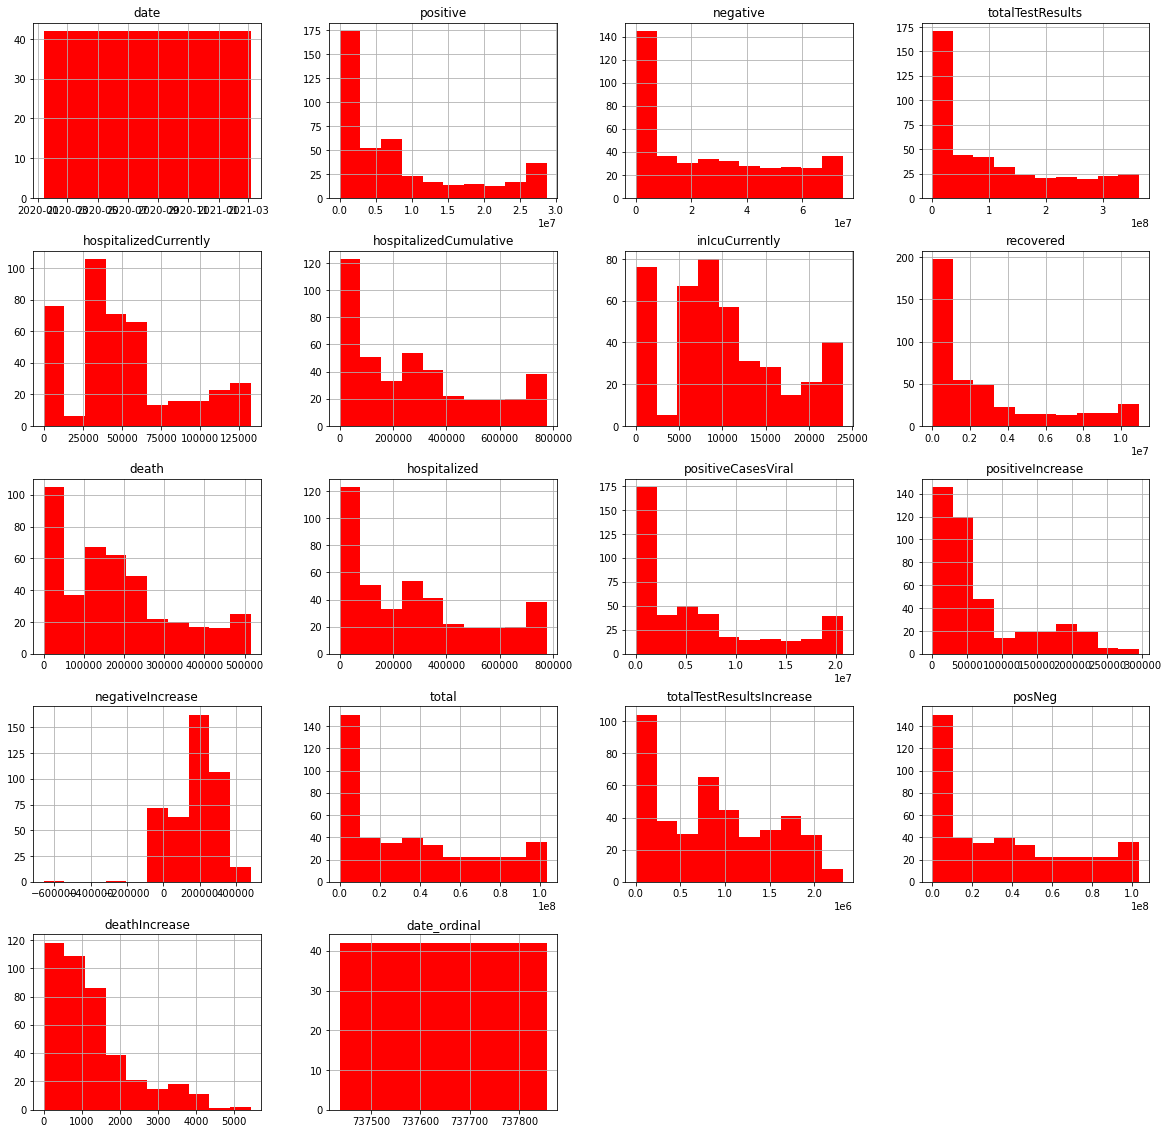

In [218]:
data_df.hist(figsize=(20,20), color='red')
plt.show()

## Plot 

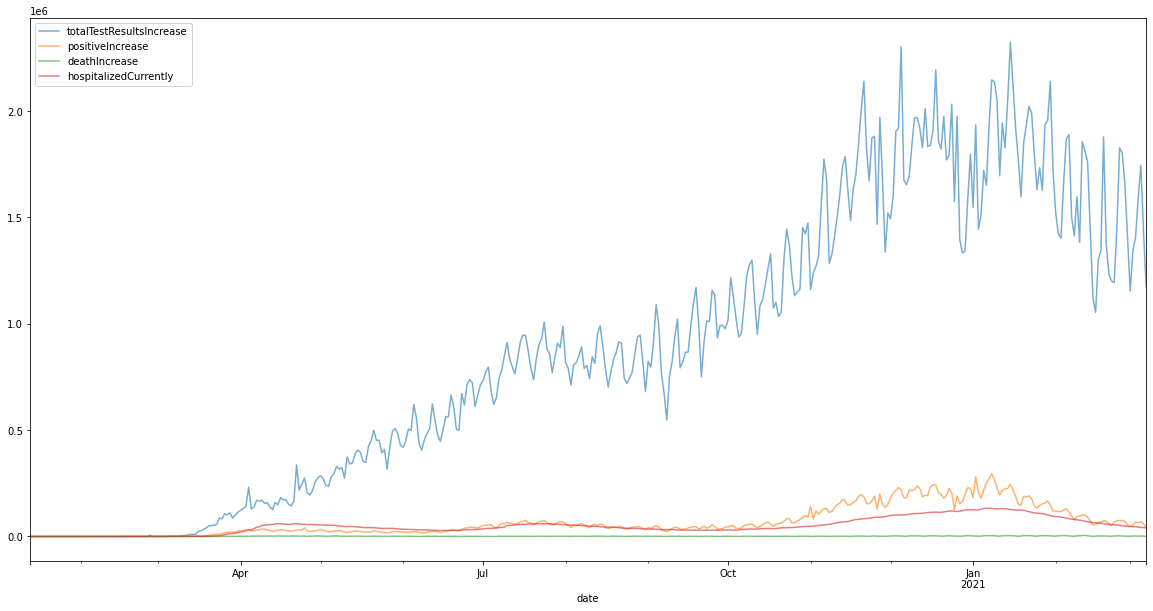

In [219]:
data_df[["date","totalTestResultsIncrease", "positiveIncrease", "deathIncrease", "hospitalizedCurrently"]].plot(x="date", figsize=(20,10),alpha=0.6)
plt.show()

# Conclusion

We've successfully executed Data extraction and Exploratory Data Analysis (EDA) for insights generation.